# Calculate harmonics of the baroclinic sea surface height data

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask import delayed
from dask_jobqueue import SLURMCluster

In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(8)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.105:42091 Dashboard: http://146.118.38.105:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [28]:
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
from netCDF4 import Dataset
import numpy as np
from glob import glob
from datetime import datetime
import re

# from soda.dataio.suntans.sunxray import Sundask, Sunxray
# from soda.utils.myproj import MyProj
# from soda.utils.otherplot import axcolorbar
import soda.utils.harmonic_analysis as ha
from soda.utils.othertime import SecondsSince
# from soda.dataio.suntans.suntans_ugrid import ugrid

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

import matplotlib.pyplot as plt

In [11]:
#basedir = '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/'
#romsfiles = '{}/qck_*.nc'.format(basedir)

basedir = '/scratch/pawsey0219/ijanekovic/ROMS_CYCLE/outputs/verification'
romsverfile = '{}/qck_ver_*.nc'.format(basedir)
#roms = xr.open_dataset(romsfile, chunks={})

roms = xr.open_mfdataset(sorted(glob(romsverfile)), concat_dim='ocean_time', 
                        parallel=True)
roms

<xarray.Dataset>
Dimensions:          (boundary: 4, eta_psi: 481, eta_rho: 482, eta_u: 482, eta_v: 481, ocean_time: 2910, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 1009, xi_rho: 1010, xi_u: 1009, xi_v: 1010)
Coordinates:
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_v            (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lat_v            (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lat_psi          (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time       (ocean_time) datetime64[ns] 2017-02-01 ... 2017-06-01
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes           (ocean_time) int32 3456 3456 3456 3456 ... 3456 3456 3456
    ndtfast          (ocean_time) int32 30 30 30 30 30 30 ... 30 30 30 30 30 30
    dt               (ocean_time) float64 100.0 100.0 100.0 ... 100.0 100.0
    dtfast           (ocean_time) float64 3.333 3.333 3.333 ... 3.333 3.333
    dstart           (ocean_time) datetime64[ns] 2017-02-01 ... 2017-05-28
    nHIS             (ocean_time) int32 72 72 72 72 72 72 ... 72 72 72 72 72 72
    ndefHIS          (ocean_time) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nRST             (ocean_time) int32 3456 3456 3456 3456 ... 3456 3456 3456
    ntsAVG           (ocean_time) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    nAVG             (ocean_time) int32 864 864 864 864 864 ... 864 864 864 864
    ndefAVG          (ocean_time) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nSTA             (ocean_time) int32 18 18 18 18 18 18 ... 18 18 18 18 18 18
    Falpha           (ocean_time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    Fbeta            (ocean_time) float64 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    Fgamma           (ocean_time) float64 0.284 0.284 0.284 ... 0.284 0.284
    nl_tnu2          (ocean_time, tracer) float64 dask.array<chunksize=(97, 2), meta=np.ndarray>
    nl_visc2         (ocean_time) float64 15.0 15.0 15.0 15.0 ... 15.0 15.0 15.0
    LuvSponge        (ocean_time) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    LtracerSponge    (ocean_time, tracer) int32 dask.array<chunksize=(97, 2), meta=np.ndarray>
    Akt_bak          (ocean_time, tracer) float64 dask.array<chunksize=(97, 2), meta=np.ndarray>
    Akv_bak          (ocean_time) float64 1e-05 1e-05 1e-05 ... 1e-05 1e-05
    Akk_bak          (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06
    Akp_bak          (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06
    rdrg             (ocean_time) float64 0.0003 0.0003 0.0003 ... 0.0003 0.0003
    rdrg2            (ocean_time) float64 0.003 0.003 0.003 ... 0.003 0.003
    Zob              (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Zos              (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Znudg            (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M2nudg           (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M3nudg           (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    Tnudg            (ocean_time, tracer) float64 dask.array<chunksize=(97, 2), meta=np.ndarray>
    FSobc_in         (ocean_time, boundary) float64 dask.array<chunksize=(97, 4), meta=np.ndarray>
    FSobc_out        (ocean_time, boundary) float64 dask.ar

In [57]:
# Let's try lazy loading all of the data and chunk 
ssh = roms['zeta'].chunk({'ocean_time':-1, 'eta_rho':-1, 'xi_rho':1})
ssh

,Array,Chunk
Bytes,5.67 GB,5.61 MB
Shape,"(2910, 482, 1010)","(2910, 482, 1)"
Count,2723 Tasks,1010 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.89 MB,3.86 kB
Shape,"(482, 1010)","(482, 1)"
Count,2165 Tasks,1010 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [41]:
# Compute the variance along the time axis
ssh_var = ssh.var(axis=0)
ssh_var = ssh_var.compute()

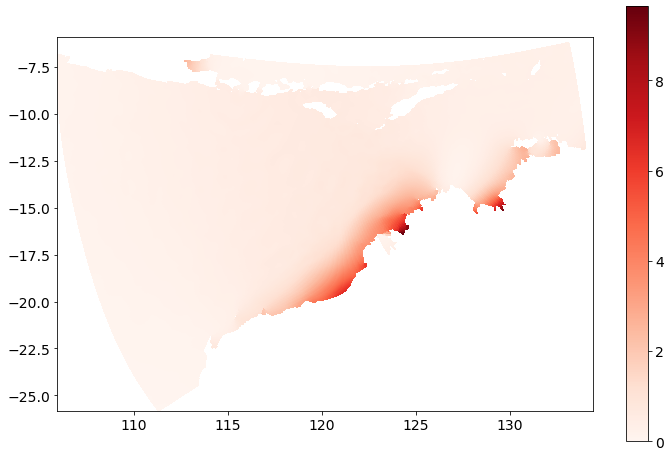

In [42]:
plt.figure(figsize=(12,8))
plt.pcolormesh(roms.lon_rho, roms.lat_rho, ssh_var, cmap='Reds', vmin=0)
plt.colorbar()
plt.gca().set_aspect('equal')

In [129]:
def build_lhs_dask(t,frq):
    """
    Construct matrix A
    """
    nt=t.shape[0]
    frq = np.array(frq)
    
    nf=frq.shape[0]
    nff=nf*2+1
    A=np.ones((nt,nff))
    for ff in range(0,nf):
        A[:,ff*2+1]=np.cos(frq[ff]*t)
        A[:,ff*2+2]=np.sin(frq[ff]*t)

    return dask.array.from_array(A, chunks=(A.shape[0],A.shape[1]))

def lstsq_dask(A,y):    
    """    
    Solve the least square problem

    Return:
        the complex amplitude 
        the mean
    """
    N=A.shape[1]
    sz = y.shape
    
    # Need to reshape the "y" array so that time is along the first dimension 
    # and all other dimensions are along the second 
    # (this probably uses up more memory than it should)
    b,res,rank,s = dask.array.linalg.lstsq(A, y.reshape(sz[0], np.prod(sz[1:])) )

    return b.reshape((N,)+sz[1:])


def harmonic_fit_dask(X, t, omega, A=None):
    
    if A is None:
        A = build_lhs_dask(t, omega)

    
    print('A: ',A.shape)
    print('X:',X.shape)
    
    # Remove NaNs
    X[dask.array.isnan(X)] = 0.

    # Least-squares matrix approach
    b = lstsq_dask(A, X) # This works on all columns of X!!
    print('b', b.shape)

    return b, A

twopi = 2*np.pi
tdaysec = 86400.

def nonstat_harmonic_fit_dask(X, t, omega, na, omega_A=twopi/(365*tdaysec), A=None):
    frq_all =[]
    for ff in omega:
        for n in range(-na,na+1):
            frq_all.append(ff+n*omega_A)

    Y, Alhs = harmonic_fit_dask(X, t, frq_all, A=A)
    
    # Break up the 
    aa = Y[0,...]
    Aa = Y[1::2,...]
    Ba = Y[2::2,...]
    
    return aa, Aa, Ba, frq_all, Alhs

In [130]:
reftime = datetime(1990,1,1)


In [131]:
# Do the harmonic fits
frq, names = ha.getTideFreq(['M2','S2','N2','K1','O1'])
time = SecondsSince(roms.ocean_time.values, basetime=reftime)
na = 0 # Number of annual harmonics to include
ii = 0

# We need to feed this function the dask.array and not the xarray.dataArray object
aa, Aa, Ba, frq_all,Alhs = nonstat_harmonic_fit_dask(ssh.data, time, frq, na)

# Alhs=None
# for ii in range(5):
#     Y = harmonic_fit_dask(ssh[:,:,ii], time, frq_all, A=Alhs)
# aa

A:  (2910, 11)
X: (2910, 482, 1010)
b (11, 482, 1010)


In [132]:
aa

,Array,Chunk
Bytes,3.89 MB,8.08 kB
Shape,"(482, 1010)","(1, 1010)"
Count,10588 Tasks,482 Chunks
Type,float64,numpy.ndarray


In [133]:
# Let's load up everything in memory
aa = aa.persist()
Aa = Aa.persist()
Ba = Ba.persist()

In [134]:
aa, Aa

(dask.array<getitem, shape=(482, 1010), dtype=float64, chunksize=(1, 1010), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(5, 482, 1010), dtype=float64, chunksize=(5, 1, 1010), chunktype=numpy.ndarray>)

In [137]:
amp = np.abs(Aa[0,...] + 1j*Ba[0,...])
amp[np.isnan(amp)] =0 
aa[np.isnan(aa)] =0 

#amp.compute()

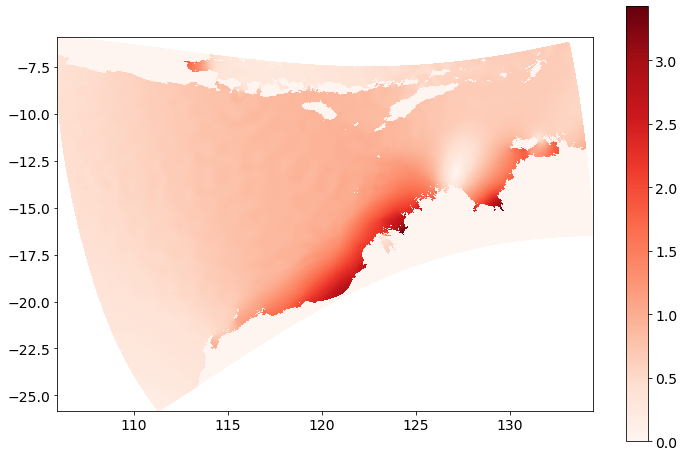

In [141]:
plt.figure(figsize=(12,8))
plt.pcolormesh(roms.lon_rho, roms.lat_rho, amp, cmap='Reds')
plt.colorbar()
plt.gca().set_aspect('equal')

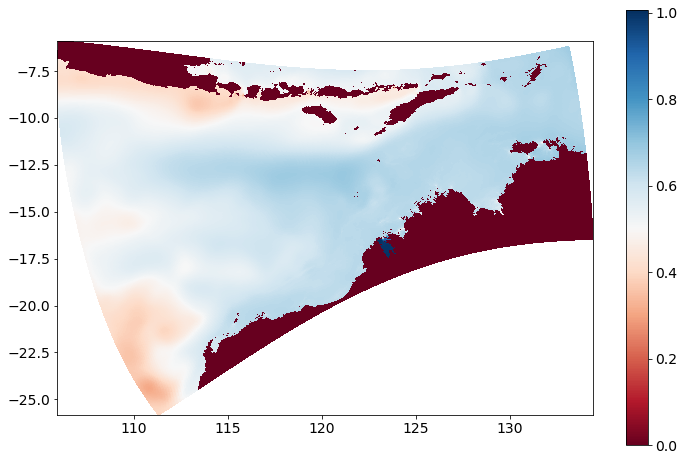

In [142]:
plt.figure(figsize=(12,8))
plt.pcolormesh(roms.lon_rho, roms.lat_rho, aa, cmap='RdBu')
plt.colorbar()
plt.gca().set_aspect('equal')

# Old stuff

In [28]:
outfile = '../SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_GLORYS_hex_2013_2014_SSHBC_Harmonics.nc'

In [29]:
# Write the output to disk
writeNC(sun, outfile)

No dimension: Ne


In [30]:
nc = Dataset(outfile,'a')

nc.Title = 'SUNTANS non-stationary harmonic output'
nc.Constituent_Names = ' '.join(names)
nc.Number_Annual_Harmonics = na
mytime = datetime.strftime(reftime,'%Y-%m-%d %H:%M:%S')
nc.ReferenceDate = mytime
#nc.SimulationTime = '%s - %s'%(datetime.strftime(self.time[self.tstep[0]],'%Y-%m-%d %H:%M:%S'),datetime.strftime(self.time[self.tstep[-1]],'%Y-%m-%d %H:%M:%S'))

Ntide = len(frq_all)
# Add another dimension
nc.createDimension('Ntide', Ntide)

write_nc_var(nc,frq_all, 'omega', ('Ntide',),\
        {'long_name':'frequency','units':'rad s-1'})


# Create the output variables
vv='SSH_BC'
units = 'm'
dims = ('Ntide','Nc')
coords = 'omega xv yv'

name = vv+'_var'
longname = '%s - signal variance'%vv
write_nc_var(nc, ssh_var, name, ('Nc',),\
    {'long_name':longname,'units':'m^2','coordinates':coords},\
        )


name = vv+'_aa'
longname = '%s - mean amplitude'%vv
write_nc_var(nc, aa, name, ('Nc',),\
    {'long_name':longname,'units':units,'coordinates':coords},\
        )

name = vv+'_Aa'
longname = '%s - real complex amplitude'%vv
write_nc_var(nc, Aa, name, dims,\
    {'long_name':longname,'units':units,'coordinates':coords},\
        )

name = vv+'_Ba'
longname = '%s - imaginary complex amplitude'%vv
write_nc_var(nc, Ba, name, dims,\
    {'long_name':longname,'units':units,'coordinates':coords},\
        )

nc.close()


In [31]:
# Test opening the file
ds = xr.open_dataset(outfile)
ds

<xarray.Dataset>
Dimensions:     (Nc: 225368, Np: 454016, Ntide: 35, numsides: 8)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nc, Np, Ntide, numsides
Data variables:
    cells       (Nc, numsides) int32 ...
    xp          (Np) float64 ...
    yp          (Np) float64 ...
    nfaces      (Nc) int32 ...
    SSH_BC_var  (Nc) float64 ...
    SSH_BC_aa   (Nc) float64 ...
    SSH_BC_Aa   (Ntide, Nc) float64 ...
    SSH_BC_Ba   (Ntide, Nc) float64 ...
Attributes:
    Description:              SUNTANS History file
    Author:                   
    Created:                  2020-07-09T16:11:13.143664
    Title:                    SUNTANS non-stationary harmonic output
    Constituent_Names:        M2 S2 N2 K1 O1
    Number_Annual_Harmonics:  3
    ReferenceDate:            1990-01-01 00:00:00

In [32]:
sun2 = Sunxray(outfile)

/home/mrayson/code/soda/soda/dataio/suntans/sunxray.py:53: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  mask_and_scale=True, decode_times=True)
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the data

In [33]:
sun2

<xarray.Dataset>
Dimensions:     (Nc: 225368, Np: 454016, Ntide: 35, numsides: 8)
Coordinates:
    omega       (Ntide) float64 0.0001399 0.0001401 ... 6.8e-05 6.82e-05
    yv          (Nc) float64 -2.188e+06 -2.2e+06 ... -1.463e+06 -1.458e+06
    xv          (Nc) float64 1.213e+07 1.214e+07 ... 1.31e+07 1.312e+07
Dimensions without coordinates: Nc, Np, Ntide, numsides
Data variables:
    xp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    SSH_BC_Ba   (Ntide, Nc) float64 dask.array<chunksize=(35, 225368), meta=np.ndarray>
    cells       (Nc, numsides) int32 dask.array<chunksize=(225368, 8), meta=np.ndarray>
    yp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    SSH_BC_aa   (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    nfaces      (Nc) int32 dask.array<chunksize=(225368,), meta=np.ndarray>
    SSH_BC_var  (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    SSH_BC_Aa   (Ntide, Nc) float64 dask.array<ch